# Ungraded Lab: Building Models for the IMDB Reviews Dataset

In this lab, you will build four models and train it on the [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) with full word encoding. These use different layers after the embedding namely `Flatten`, `LSTM`, `GRU`, and `Conv1D`. You will compare the performance and see which architecture might be best for this particular dataset. Let's begin!

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Download and Prepare the Dataset

Next, you will download the `plain_text` version of the `IMDB Reviews` dataset.

In [ ]:
import tensorflow_datasets as tfds

# The dataset is already downloaded for you. For downloading you can use the code below.
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="./data/", download=True)

In [ ]:
# Get the train and test sets
train_dataset, test_dataset = imdb['train'], imdb['test']

Then, you will build the vocabulary based on the training set.

In [ ]:
# Vectorization and Padding Parameters

VOCAB_SIZE = 10000
MAX_LENGTH = 120
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [ ]:
import tensorflow as tf

def setup_vectorization_layer(train_dataset, vocab_size):
    """
    Sets up a TextVectorization layer based on the training dataset.

    Args:
        train_dataset (tf.data.Dataset): The training dataset containing text reviews and labels.
        vocab_size (int): The maximum size of the vocabulary.

    Returns:
        tf.keras.layers.TextVectorization: The configured TextVectorization layer.
    """

    # Instantiate the vectorization layer
    vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)

    # Get the string inputs from the training set
    train_reviews = train_dataset.map(lambda review, label: review)

    # Generate the vocabulary based only on the training set
    vectorize_layer.adapt(train_reviews)

    # Delete the temporary dataset because it's no longer needed
    del train_reviews

    return vectorize_layer

vectorize_layer = setup_vectorization_layer(train_dataset, VOCAB_SIZE)

In Week 2, you generated the padded sequences by chaining `map()` and `apply()` methods. Here's a similar way to do that. You will just call an `apply()` then do the transformations in one preprocessing function.

In [ ]:
def preprocessing_fn(dataset):
    """
      Generates padded sequences from a tf.data.Dataset.

      Args:
          dataset (tf.data.Dataset): Dataset containing text features and labels.

      Returns:
          tf.data.Dataset: Dataset containing the tokenized and padded sequences along with their labels.
      """

    # Apply the vectorization layer to the string features
    dataset_sequences = dataset.map(
        lambda text, label: (vectorize_layer(text), label)
        )

    # Put all elements in a single ragged batch
    dataset_sequences = dataset_sequences.ragged_batch(
        batch_size=dataset_sequences.cardinality()
        )

    # Output a tensor from the single batch. Extract the sequences and labels.
    sequences, labels = dataset_sequences.get_single_element()

    # Pad the sequences
    padded_sequences = tf.keras.utils.pad_sequences(
        sequences.numpy(),
        maxlen=MAX_LENGTH,
        truncating=TRUNC_TYPE,
        padding=PADDING_TYPE
        )

    # Convert back to a tf.data.Dataset
    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
    labels = tf.data.Dataset.from_tensor_slices(labels)

    # Combine the padded sequences and labels
    dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

    return dataset_vectorized

In [ ]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

View a couple of examples. You should see tuples of tensors with a padded sequence and label.

In [ ]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print('='*80)

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,   11,   14,   34,  412,  384,   18,   90,
         28,    1,    8,   33, 1322, 3560,   42,  487,    1,  191,   24,
         85,  152,   19,   11,  217,  316,   28,   65,  240,  214,    8,
        489,   54,   65,   85,  112,   96,   22, 5596,   11,   93,  642,
        743,   11,   18,    7,   34,  394, 9522,  170, 2464,  408,    2,
         88, 1216,  137,   66,  144,   51,    2,    1, 7558,   66,  245,
         65, 2870,   16,    1, 2860,    1,    1, 1426, 5050,    3,   40,
          1, 1579,   17, 3560,   14,  158,   19,    4, 1216,  891, 8040,
          8,    4,   18,   12,   14, 4059,    5,   99,  146, 1241,   10,
        237,  704,   12,   48,   24,   93,   39,   11, 7339,  152,   39,
       1322,    1,   50,  398,   10,   96, 1155,  851,  141,    9],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,

You will do the optimization and batching as usual.

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

def optimize_dataset(dataset_vectorized, shuffle=False):
    '''
    Optimizes the dataset for training.

    Args:
        dataset_vectorized (tf.data.Dataset): Dataset containing the vectorized data.
        shuffle (bool): Indicates whether to shuffle the dataset or not. Default is False.

    Returns:
        tf.data.Dataset: Optimized dataset with caching, prefetching, and batching applied.
    '''
    dataset_final = dataset_vectorized.cache()
    dataset_final = dataset_final.shuffle(SHUFFLE_BUFFER_SIZE) if shuffle else dataset_final
    dataset_final = dataset_final.prefetch(buffer_size=PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset_final

train_dataset_final = optimize_dataset(train_dataset_vectorized, shuffle=True)
test_dataset_final = optimize_dataset(test_dataset_vectorized)

## Plot Utility

The function below will visualize the accuracy and loss history after training.

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history):
    """
    Plots training and validation metrics (accuracy and loss) over epochs in subplots.

    Args:
        history (History): History object returned by the fit method of a Keras model.

    Returns:
        None: Displays a figure with two subplots for accuracy and loss.
    """
    metrics = ['accuracy', 'loss']

    # Create a figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    for i, metric in enumerate(metrics):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history[f'val_{metric}'])
        axs[i].set_title(f'TRAINING AND VALIDATION {metric.upper()}')
        axs[i].set_xlabel("Epochs")
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend([metric, f'val_{metric}'])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

## Model 1: Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Flatten, Dense

class FlattenModel:
    def __init__(self, max_length, vocab_size, embedding_dim, dense_dim):
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dense_dim = dense_dim
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Input(shape=(self.max_length,)),
            Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim),
            Flatten(),
            Dense(self.dense_dim, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        return model

    def compile_model(self):
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train_model(self, train_data, test_data, num_epochs, verbose):
        history = self.model.fit(
            train_data,
            epochs=num_epochs,
            validation_data=test_data,
            verbose=verbose
        )
        return history

    def summary(self):
        self.model.summary()

In [ ]:
# Parameters
EMBEDDING_DIM = 16
DENSE_DIM = 6

# Create an instance of the SentimentModel class
flatten_model = FlattenModel(MAX_LENGTH, VOCAB_SIZE, EMBEDDING_DIM, DENSE_DIM)

# Print the summary
flatten_model.summary()

# Compile the model
flatten_model.compile_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │          11,526 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,533 (670.05 KB)

 Trainable params: 171,533 (670.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
NUM_EPOCHS = 10

flatten_history = flatten_model.train_model(train_data=train_dataset_final, test_data=test_dataset_final, num_epochs=NUM_EPOCHS, verbose=1)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6101 - loss: 0.6227 - val_accuracy: 0.8135 - val_loss: 0.4014
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8720 - loss: 0.3039 - val_accuracy: 0.8062 - val_loss: 0.4405
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9558 - loss: 0.1411 - val_accuracy: 0.8060 - val_loss: 0.5168
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9924 - loss: 0.0365 - val_accuracy: 0.8051 - val_loss: 0.6001
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9989 - loss: 0.0086 - val_accuracy: 0.8059 - val_loss: 0.6770
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.8062 - val_loss: 0.7379
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8067 - val_loss: 0.7885
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.

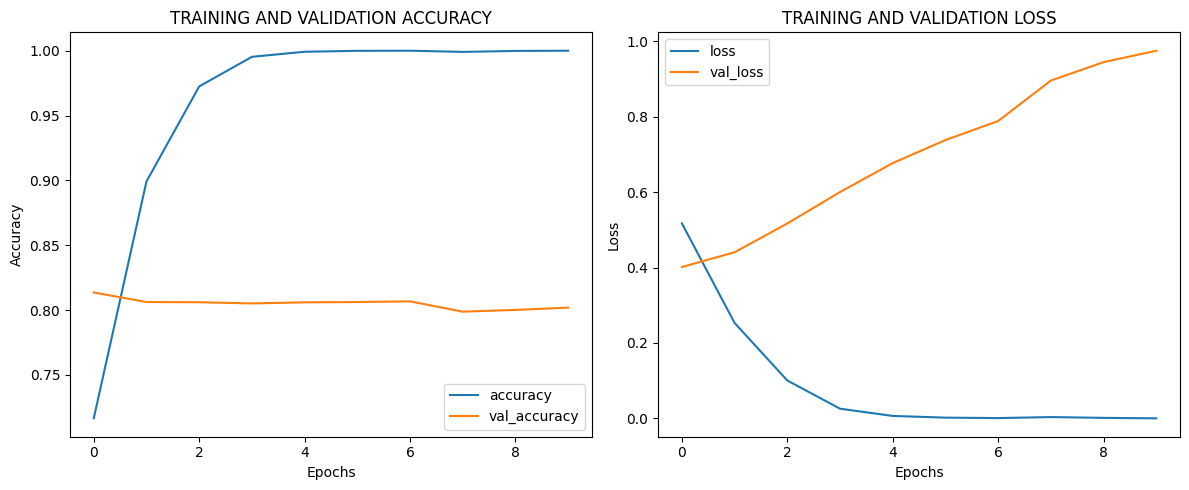

In [ ]:
# Plot the accuracy and loss history
plot_graphs(flatten_history)

## Model 2: LSTM

Next, you will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

class LSTMModel:
    def __init__(self, max_length, vocab_size, embedding_dim, lstm_dim, dense_dim):
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_dim = lstm_dim
        self.dense_dim = dense_dim
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Input(shape=(self.max_length,)),
            Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim),
            Bidirectional(LSTM(self.lstm_dim)),
            Dense(self.dense_dim, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        return model

    def compile_model(self):
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train_model(self, train_data, test_data, num_epochs, verbose):
        history = self.model.fit(
            train_data,
            epochs=num_epochs,
            validation_data=test_data,
            verbose=verbose
        )
        return history

    def summary(self):
        self.model.summary()

In [ ]:
# Parameters
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 6

# Create an instance of the SentimentModel class
lstm_model = LSTMModel(MAX_LENGTH, VOCAB_SIZE, EMBEDDING_DIM, LSTM_DIM, DENSE_DIM)

# Print the summary
lstm_model.summary()

# Compile the model
lstm_model.compile_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,941 (675.55 KB)

 Trainable params: 172,941 (675.55 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
NUM_EPOCHS = 10

lstm_history = lstm_model.train_model(train_data=train_dataset_final, test_data=test_dataset_final, num_epochs=NUM_EPOCHS, verbose=1)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 73ms/step - accuracy: 0.6621 - loss: 0.5771 - val_accuracy: 0.8264 - val_loss: 0.3958
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.8676 - loss: 0.3185 - val_accuracy: 0.8139 - val_loss: 0.4587
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.9024 - loss: 0.2529 - val_accuracy: 0.8166 - val_loss: 0.4562
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.9159 - loss: 0.2187 - val_accuracy: 0.8102 - val_loss: 0.5013
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.9417 - loss: 0.1658 - val_accuracy: 0.8028 - val_loss: 0.5480
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.9441 - loss: 0.1494 - val_accuracy: 0.7992 - val_loss: 0.6061
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.9586 - loss: 0.1138 - val_accuracy: 0.8013 - val_loss: 0.7253
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.9665 - loss: 0.0971 - 

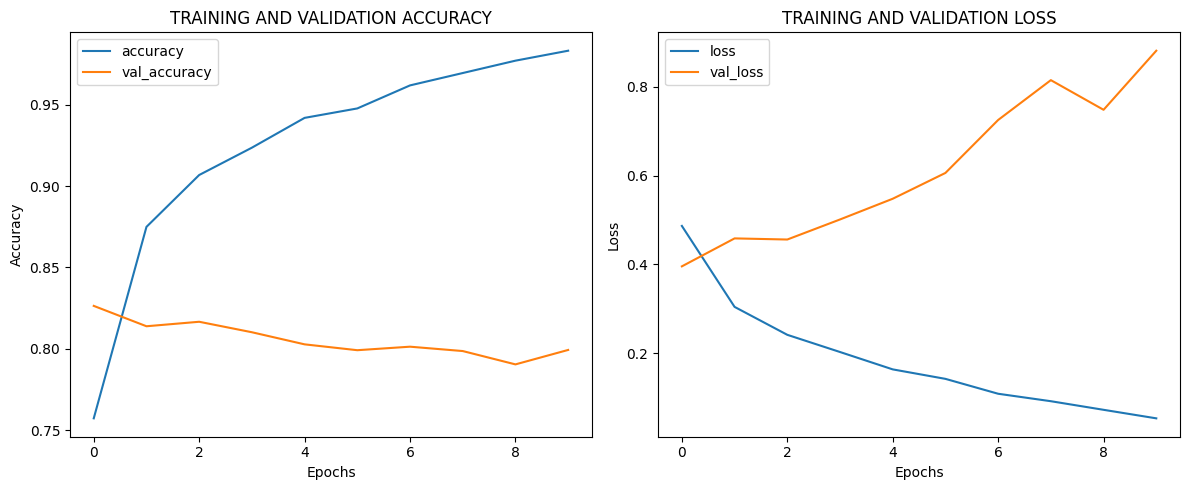

In [ ]:
# Plot the accuracy and loss history
plot_graphs(lstm_history)

## Model 3: GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense

class GRUModel:
    def __init__(self, max_length, vocab_size, embedding_dim, gru_dim, dense_dim):
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.gru_dim = gru_dim
        self.dense_dim = dense_dim
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Input(shape=(self.max_length,)),
            Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim),
            Bidirectional(GRU(self.gru_dim)),
            Dense(self.dense_dim, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        return model

    def compile_model(self):
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train_model(self, train_data, test_data, num_epochs, verbose):
        history = self.model.fit(
            train_data,
            epochs=num_epochs,
            validation_data=test_data,
            verbose=verbose
        )
        return history

    def summary(self):
        self.model.summary()

In [ ]:
# Parameters
EMBEDDING_DIM = 16
GRU_DIM = 32
DENSE_DIM = 6

# Create an instance of the SentimentModel class
gru_model = GRUModel(MAX_LENGTH, VOCAB_SIZE, EMBEDDING_DIM, GRU_DIM, DENSE_DIM)

# Print the summary
gru_model.summary()

# Compile the model
gru_model.compile_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │           9,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,997 (664.05 KB)

 Trainable params: 169,997 (664.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
NUM_EPOCHS = 10

gru_history = gru_model.train_model(train_data=train_dataset_final, test_data=test_dataset_final, num_epochs=NUM_EPOCHS, verbose=1)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 90ms/step - accuracy: 0.5953 - loss: 0.6460 - val_accuracy: 0.8032 - val_loss: 0.4293
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.8405 - loss: 0.3662 - val_accuracy: 0.8167 - val_loss: 0.4026
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step - accuracy: 0.8945 - loss: 0.2689 - val_accuracy: 0.8164 - val_loss: 0.4453
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.9209 - loss: 0.2125 - val_accuracy: 0.8149 - val_loss: 0.5828
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.9413 - loss: 0.1664 - val_accuracy: 0.8104 - val_loss: 0.5785
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.9624 - loss: 0.1160 - val_accuracy: 0.8035 - val_loss: 0.6294
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.9762 - loss: 0.0783 - val_accuracy: 0.7994 - val_loss: 0.8015
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.9809 - loss: 0.0613 - 

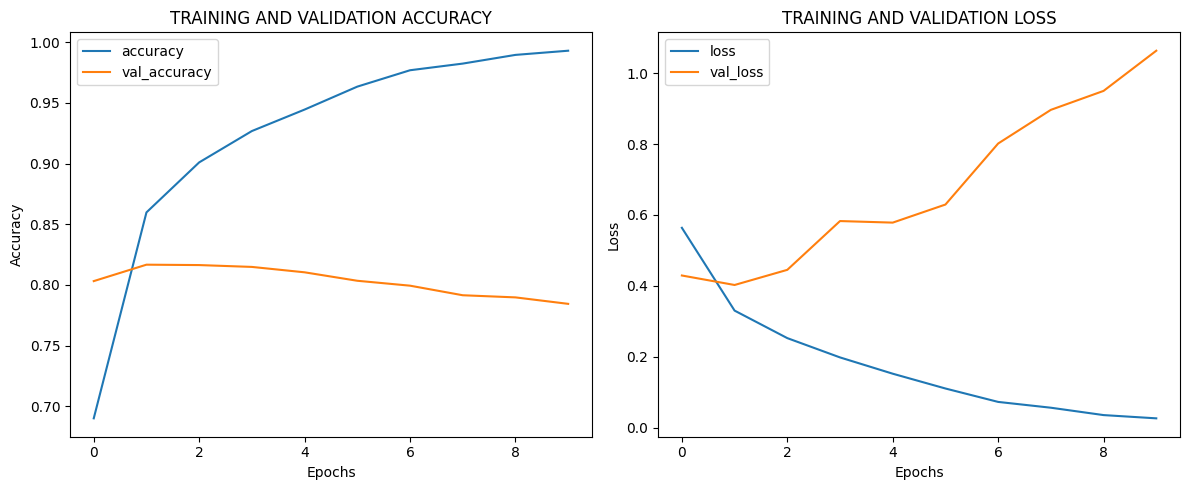

In [ ]:
# Plot the accuracy and loss history
plot_graphs(gru_history)

## Model 4: CONVOLUTION

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Bidirectional, Conv1D, GlobalAveragePooling1D, Dense

class ConvolutionalModel:
    def __init__(self, max_length, vocab_size, embedding_dim, filters, kernel_size, dense_dim):
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.filters = filters
        self.kernel_size = kernel_size
        self.dense_dim = dense_dim
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Input(shape=(self.max_length,)),
            Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim),
            Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation='relu'),
            GlobalAveragePooling1D(),
            Dense(self.dense_dim, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        return model

    def compile_model(self):
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train_model(self, train_data, test_data, num_epochs, verbose):
        history = self.model.fit(
            train_data,
            epochs=num_epochs,
            validation_data=test_data,
            verbose=verbose
        )
        return history

    def summary(self):
        self.model.summary()

In [ ]:
# Parameters
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

# Create an instance of the SentimentModel class
convolutional_model = ConvolutionalModel(MAX_LENGTH, VOCAB_SIZE, EMBEDDING_DIM, FILTERS, KERNEL_SIZE, DENSE_DIM)

# Print the summary
convolutional_model.summary()

# Compile the model
convolutional_model.compile_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 116, 128)            │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             774 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
NUM_EPOCHS = 10

convolutional_history = convolutional_model.train_model(train_data=train_dataset_final, test_data=test_dataset_final, num_epochs=NUM_EPOCHS, verbose=1)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7000 - loss: 0.5547 - val_accuracy: 0.8307 - val_loss: 0.3799
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8757 - loss: 0.2997 - val_accuracy: 0.8260 - val_loss: 0.3964
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9001 - loss: 0.2470 - val_accuracy: 0.8199 - val_loss: 0.4322
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9198 - loss: 0.2115 - val_accuracy: 0.8117 - val_loss: 0.4931
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9316 - loss: 0.1801 - val_accuracy: 0.8077 - val_loss: 0.5452
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9440 - loss: 0.1547 - val_accuracy: 0.8052 - val_loss: 0.6026
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9541 - loss: 0.1341 - val_accuracy: 0.7998 - val_loss: 0.6898
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9644 - loss: 0.1093 - val_acc

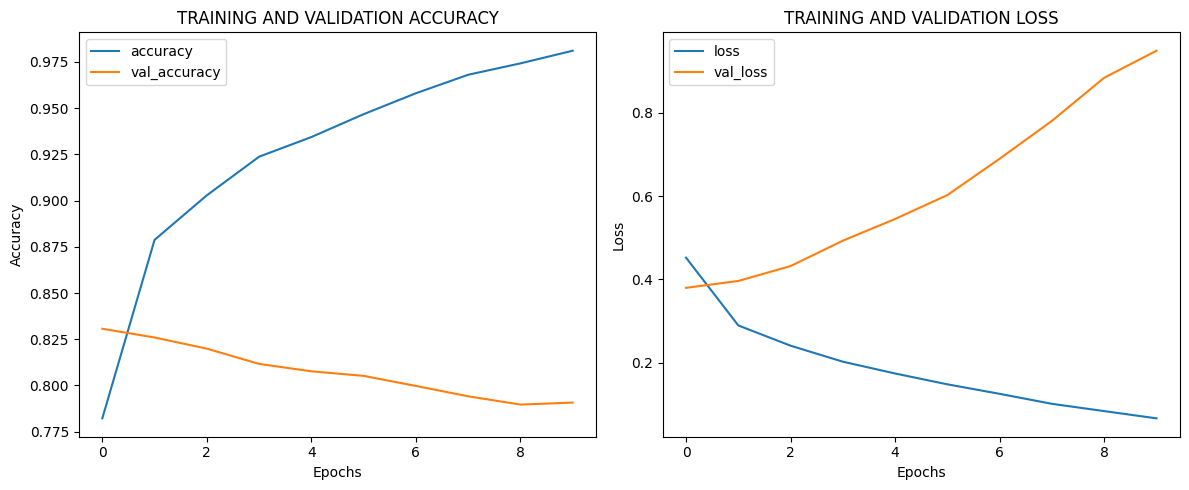

In [ ]:
# Plot the accuracy and loss history
plot_graphs(convolutional_history)

## Wrap Up

Now that you've seen the results for each model, can you make a recommendation on what works best for this dataset? Do you still get the same results if you tweak some hyperparameters like the vocabulary size? Try tweaking some of the values some more so you can get more insight on what model performs best.

Run the cell below to free up resources for the next lab

In [ ]:
# Shutdown the kernel to free up resources.
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}